### Statistical Method (AR & ARIMA)

### From scratch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
file = "../datasets/clean/df_41017.csv"
df = pd.read_csv(file, index_col=0)
df.index = pd.to_datetime(df.index)

In [3]:
train = df[df.index < pd.to_datetime("2016/01/01")]
test = df[df.index > pd.to_datetime("2016/01/01")]
print(f"Train: {train.shape}\nTest: {test.shape}")

Train: (24121, 1)
Test: (8783, 1)


In [150]:
class AutoRegressive:
    
    def __init__(self, p, df):
        self.p = p
        self.df = df
        
        df_temp = self.df
        
        for lag in range(1, self.p+1):
            df_temp[f"Shifted_values_{lag}"] = df_temp.swh.shift(lag)

        self.train = df_temp[df_temp.index < pd.to_datetime("2016/01/01")]
        self.test = df_temp[df_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        X_train = self.train.iloc[:, 1:].values.reshape(-1, self.p)
        y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = X_train.dot(self.theta) + self.intercept
        
        X_test = self.test.iloc[:, 1:].values.reshape(-1,self.p)
        
        self.test['Predicted Values'] = X_test.dot(self.theta) + self.intercept
        
    
    def predict(self, steps=100):
        self.steps = steps+1
        
        self.MSE = mean_squared_error(self.test['swh'][:self.steps-1].values, self.test['Predicted Values'][1:self.steps].values)
        
        print(f"MSE: {self.MSE} with {self.p} lags.")
        
        self.prediction = pd.DataFrame([self.test['swh'][:self.steps-1].values, self.test['Predicted Values'][1:self.steps].values]).T
        self.prediction.columns = ['Actual', 'Predicted']
        self.prediction.index = self.test.index[:steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_MSE(self):
        return self.MSE
    
    
    def get_all_residuals(self):
        train_residuals = pd.DataFrame([self.train['swh'], self.train['Predicted Values'], self.train['swh'].values - self.train['Predicted Values']]).T
        train_residuals.columns = ['Actual', 'Predicted', 'Residuals']
        test_residuals = self.prediction
        test_residuals['Residuals'] = self.prediction['Actual'] - self.prediction['Predicted']
        test_residuals.index = self.test.index[:len(self.prediction)]
        self.residuals = pd.concat([train_residuals, test_residuals])
        
        return self.residuals
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Actual.values, label='Actual')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('Autoregressive')
        plt.legend()
        plt.show()
        
        
    def plot_residuals(self):
        residuals = pd.DataFrame(self.prediction['Actual'] - self.prediction['Predicted'])
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(residuals)
        ax1.set_title("residual line plot")
        ax2 = sns.distplot(residuals)
        ax2.set_title("residual density plot")
        plt.show()
        print("Statistics:")
        print(residuals.describe())

        

class MA:
    
    def __init__(self, q, residuals):
        self.q = q
        self.residuals = residuals
        
        residuals_temp = self.residuals
                
        for lag in range(1, self.q+1):
            residuals_temp[f"Shifted_values_{lag}"] = residuals_temp.Residuals.shift(lag)

        self.train = residuals_temp[residuals_temp.index < pd.to_datetime("2016/01/01")]
        self.test = residuals_temp[residuals_temp.index > pd.to_datetime("2016/01/01")]
        
        self.train.dropna(inplace=True)
        X_train = self.train.iloc[:, 1:].values.reshape(-1, self.q)
        y_train = self.train.iloc[:, 0].values.reshape(-1,1)
        
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        
        self.theta = LR.coef_.T
        self.intercept = LR.intercept_
        
        self.train['Predicted Values'] = X_train.dot(self.theta) + self.intercept
        
        X_test = self.test.iloc[:, 1:].values.reshape(-1,self.q)
        
        self.test['Predicted Values'] = X_test.dot(self.theta) + self.intercept
        
        
    def predict(self, steps=None):
        if steps is None:
            steps = self.test
        try:
            if steps > len(self.test):
                raise ValueError(f'Maximum steps are {len(self.test)}.')
            else:
                self.steps = steps+1
        except ValueError as error:
            print(f'Value must be integer and the maximum steps are {len(self.test)} steps.')

        
        self.MSE = mean_squared_error(self.test['Residuals'][:self.steps-1].values, self.test['Predicted Values'][:self.steps].values)
        
        print(f"MSE: {self.MSE} with {self.q} lags.")
        
        self.prediction = pd.DataFrame([self.test['Residuals'][:self.steps-1].values, self.test['Predicted Values'][:self.steps].values]).T
        self.prediction.columns = ['Residuals', 'Predicted']
        self.prediction.index = self.test.index[:steps]
        
        return self.prediction
    
    
    def get_parameters(self):
        return self.theta, self.intercept
        
        
    def get_MSE(self):
        return self.MSE
    
    
    def plot_predict(self):
        plt.plot(self.prediction.Residuals.values, label='Residuals')
        plt.plot(self.prediction.Predicted.values, label='Predicted')
        plt.title('MA')
        plt.legend()
        plt.show()

#### AR

In [151]:
df2 = df.copy()
p = 2
autoregressive = AutoRegressive(p, df2)
autoregressive_pred = autoregressive.predict()
autoregressive_mse = autoregressive.get_MSE()

MSE: 0.004133927285695113 with 2 lags.


In [152]:
autoregressive_pred.head()

,Actual,Predicted
date,,
2016-01-01 00:50:00,2.59,2.595562
2016-01-01 01:50:00,2.71,2.647426
2016-01-01 02:50:00,2.88,2.793788
2016-01-01 03:50:00,2.83,2.835438
2016-01-01 04:50:00,3.11,2.974334


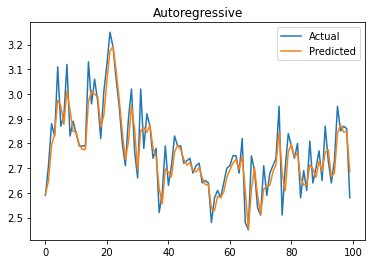

In [153]:
autoregressive.plot_predict()

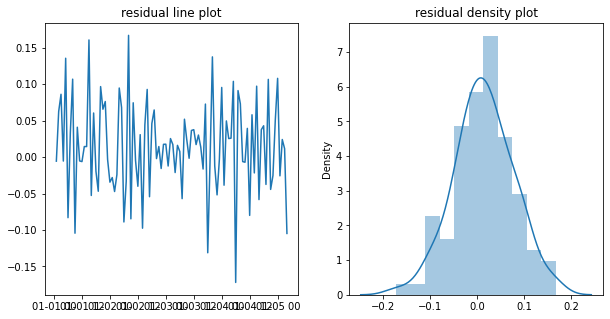

Statistics:
                0
count  100.000000
mean     0.013982
std      0.063073
min     -0.172005
25%     -0.024375
50%      0.014482
75%      0.053539
max      0.167078


In [154]:
autoregressive.plot_residuals()

In [155]:
autoregressive_resid = autoregressive.get_all_residuals()
autoregressive_resid.head()

,Actual,Predicted,Residuals
date,,,
2013-04-01 01:50:00,2.32,2.163940,0.156060
2013-04-01 02:50:00,2.47,2.256079,0.213921
2013-04-01 03:50:00,2.31,2.399298,-0.089298
2013-04-01 04:50:00,2.37,2.370027,-0.000027
2013-04-01 05:50:00,2.25,2.338199,-0.088199
...,...,...,...
2016-01-04 23:50:00,2.95,2.841920,0.108080
2016-01-05 00:50:00,2.85,2.875713,-0.025713
2016-01-05 01:50:00,2.87,2.845851,0.024149


#### MA

In [156]:
q = 11
ma_model = MA(q, autoregressive_resid[['Residuals']])
ma_pred = ma_model.predict(100)
ma_mse = ma_model.get_MSE()

MSE: 0.003919785217843374 with 11 lags.


In [157]:
ma_pred.head()

,Residuals,Predicted
date,,
2016-01-01 00:50:00,-0.005562,0.020883
2016-01-01 01:50:00,0.062574,-0.020279
2016-01-01 02:50:00,0.086212,0.002792
2016-01-01 03:50:00,-0.005438,-0.018284
2016-01-01 04:50:00,0.135666,-0.015899
...,...,...
2016-01-04 23:50:00,0.108080,0.001130
2016-01-05 00:50:00,-0.025713,-0.013782
2016-01-05 01:50:00,0.024149,-0.009989


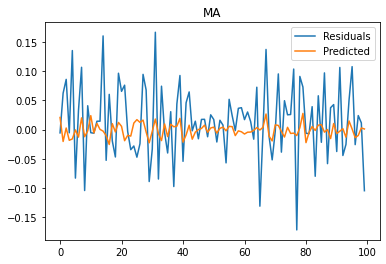

In [158]:
ma_model.plot_predict()

#### Final (ARIMA)

In [159]:
final_pred = autoregressive_pred['Predicted'] + ma_pred['Predicted'].values

In [164]:
ARIMA = pd.DataFrame([autoregressive_pred['Actual'].values, final_pred, autoregressive_pred['Actual'].values-final_pred]).T
ARIMA.columns = ['Actual', 'Predicted', 'Residuals']
ARIMA.index = autoregressive_pred.index

In [165]:
ARIMA.head()

,Actual,Predicted,Residuals
date,,,
2016-01-01 00:50:00,2.59,2.616445,-0.026445
2016-01-01 01:50:00,2.71,2.627147,0.082853
2016-01-01 02:50:00,2.88,2.796580,0.083420
2016-01-01 03:50:00,2.83,2.817155,0.012845
2016-01-01 04:50:00,3.11,2.958435,0.151565
...,...,...,...
2016-01-04 23:50:00,2.95,2.843051,0.106949
2016-01-05 00:50:00,2.85,2.861930,-0.011930
2016-01-05 01:50:00,2.87,2.835861,0.034139


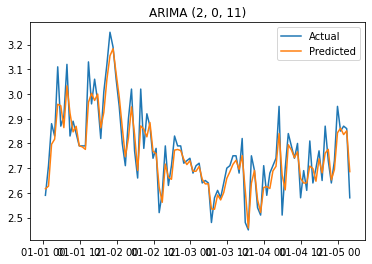

MSE: 0.003919785217843374


In [167]:
plt.plot(ARIMA.Actual, label='Actual')
plt.plot(ARIMA.Predicted, label='Predicted')
plt.title(f'ARIMA ({p}, 0, {q})')
plt.legend()
plt.show()
print(f"MSE: {mean_squared_error(ARIMA.Actual, ARIMA.Predicted)}")

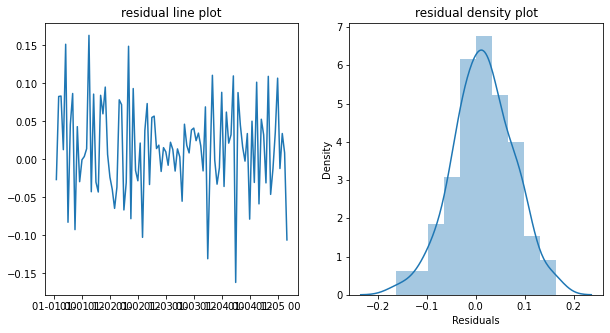

count    100.000000
mean       0.014827
std        0.061133
min       -0.161836
25%       -0.028359
50%        0.014204
75%        0.053483
max        0.163281
Name: Residuals, dtype: float64

In [168]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(ARIMA.Residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(ARIMA.Residuals)
ax2.set_title("residual density plot")
plt.show()
ARIMA.Residuals.describe()

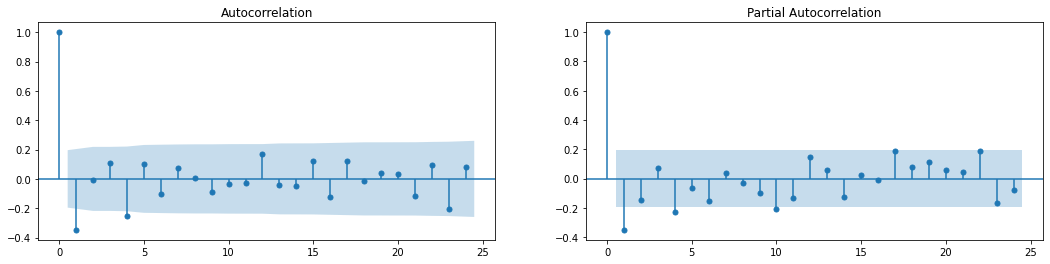

In [169]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(ARIMA.Residuals, lags=24, ax=ax1)
ax2 = plot_pacf(ARIMA.Residuals, lags=24, ax=ax2)

### Using modules

In [170]:
from math import sqrt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm # auto arima
# from sklearn.model_selection import TimeSeriesSplit

#### Autoregressive

In [171]:
def AutoRegressiveModel(train_data, test_data, lags, steps):
    """
    Autoregression using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()
    residuals = list()
    steps += 1

    for t in tqdm(range(len(test_data[:steps]))):
        model = AutoReg(history, lags=lags).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    mse = mean_squared_error(test_data[:steps-1],predictions[1:])
    
    return predictions[1:], mse

In [172]:
ar_predictions, ar_mse = AutoRegressiveModel(train.swh.values, test.swh.values, 2, 100)

100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 110.71it/s]


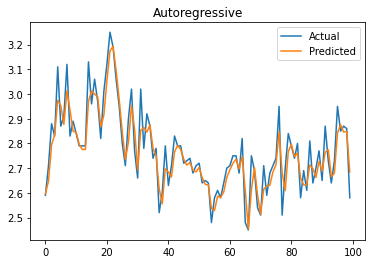

MSE of AR: 0.004126727232378868


In [173]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(ar_predictions, label="Predicted")
plt.title('Autoregressive')
plt.legend()
plt.show()
print(f"MSE of AR: {ar_mse}")

#### ARIMA

In [174]:
def ArimaModel(train_data, test_data, arima_order: tuple, steps):
    """
    Arima using walk forward validation
    """
    history = [x for x in train_data]
    predictions = list()
    steps += 1

    for t in tqdm(range(len(test_data[:steps]))):
        model = ARIMA(history, order=arima_order).fit()
        output = model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_data[t]
        history.append(obs)
        
    mse = mean_squared_error(test_data[:steps-1],predictions[1:])
    
    return predictions[1:], mse

In [175]:
pqd = (2,0,11)
arima_predictions, arima_mse = ArimaModel(train.swh.values, test.swh.values, pqd, 100)

100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [24:43<00:00, 14.69s/it]


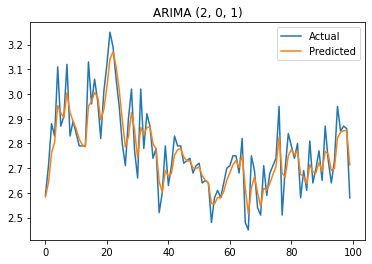

MSE of ARIMA: 0.0046483278711657375


In [119]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(arima_predictions, label="Predicted")
plt.title(f'ARIMA {pqd}')
plt.legend()
plt.show()
print(f"MSE of ARIMA: {arima_mse}")

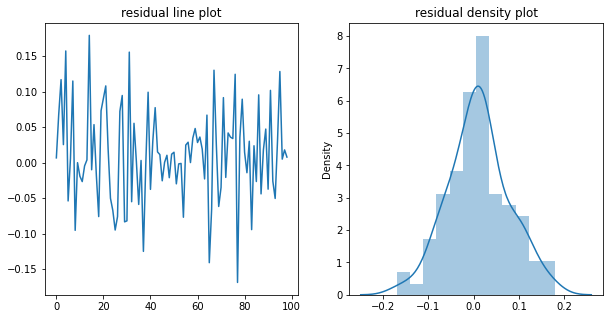

,0
count,99.000000
mean,0.011058
std,0.066627
min,-0.168862
25%,-0.026620
50%,0.010418
75%,0.044634
max,0.179495


In [161]:
residuals = pd.DataFrame(test.swh.values[:99] - arima_predictions)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
ax1.plot(residuals)
ax1.set_title("residual line plot")
ax2 = sns.distplot(residuals)
ax2.set_title("residual density plot")
plt.show()
residuals.describe()

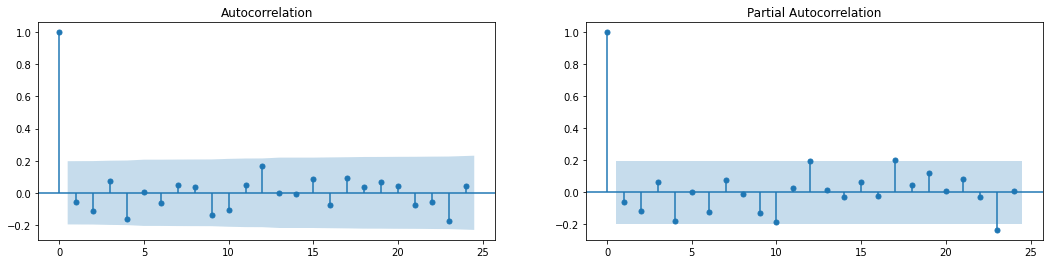

In [158]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18, 4))
ax1 = plot_acf(residuals, lags=24, ax=ax1)
ax2 = plot_pacf(residuals, lags=24, ax=ax2)

Search for the best fit parameter

In [17]:
def GridArimaModel(train_data, test_data, p_values: list, d_values: list, q_values: list, steps):
    """
    Best fit Arima using walk forward validation
    """
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    _, mse = ArimaModel(train_data, test_data, (p,d,q), steps)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue

    predictions, mse = ArimaModel(train_data, test_data, best_cfg, steps)

    return predictions, best_cfg, best_score

In [22]:
best_prediction, best_cfg, best_score = GridArimaModel(train.swh.values, test.swh.values,list(range(1,3)), [0], [1], 100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:22<00:00,  2.03s/it]


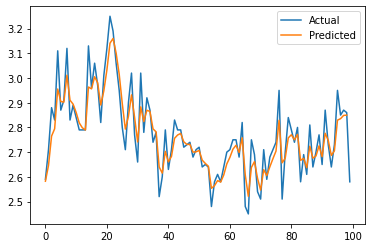

Best parameter of order: (1, 0, 1)
MSE of ARIMA: 0.0038912259457331453


In [23]:
plt.plot(test.swh.values[:100], label="Actual")
plt.plot(best_prediction, label="Predicted")
plt.legend()
plt.show()
print(f"Best parameter of order: {best_cfg}")
print(f"MSE of ARIMA: {best_score}")

----